In [11]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline

In [24]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100).view(1, -1, 1).repeat(4, 1, 1)

# True function is sin(2*pi*x) with Gaussian noise
sin_y = torch.sin(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
sin_y_short = torch.sin(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y = torch.cos(train_x[0] * (2 * math.pi)) + 0.5 * torch.rand(1, 100, 1)
cos_y_short = torch.cos(train_x[0] * (math.pi)) + 0.5 * torch.rand(1, 100, 1)
train_y = torch.cat((sin_y, sin_y_short, cos_y, cos_y_short)).squeeze(-1)

In [25]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_size=4)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(batch_size=4), batch_size=4
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_size=4)
model = ExactGPModel(train_x, train_y, likelihood)

In [26]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 100
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y).sum()
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 3.438
Iter 2/100 - Loss: 3.277
Iter 3/100 - Loss: 3.117
Iter 4/100 - Loss: 2.955
Iter 5/100 - Loss: 2.793
Iter 6/100 - Loss: 2.637
Iter 7/100 - Loss: 2.480
Iter 8/100 - Loss: 2.320
Iter 9/100 - Loss: 2.171
Iter 10/100 - Loss: 2.016
Iter 11/100 - Loss: 1.866
Iter 12/100 - Loss: 1.705
Iter 13/100 - Loss: 1.569
Iter 14/100 - Loss: 1.404
Iter 15/100 - Loss: 1.244
Iter 16/100 - Loss: 1.101
Iter 17/100 - Loss: 0.937
Iter 18/100 - Loss: 0.782
Iter 19/100 - Loss: 0.611
Iter 20/100 - Loss: 0.454
Iter 21/100 - Loss: 0.322
Iter 22/100 - Loss: 0.169
Iter 23/100 - Loss: 0.003
Iter 24/100 - Loss: -0.140
Iter 25/100 - Loss: -0.273
Iter 26/100 - Loss: -0.423
Iter 27/100 - Loss: -0.548
Iter 28/100 - Loss: -0.664
Iter 29/100 - Loss: -0.788
Iter 30/100 - Loss: -0.908
Iter 31/100 - Loss: -1.012
Iter 32/100 - Loss: -1.106
Iter 33/100 - Loss: -1.203
Iter 34/100 - Loss: -1.275
Iter 35/100 - Loss: -1.334
Iter 36/100 - Loss: -1.428
Iter 37/100 - Loss: -1.471
Iter 38/100 - Loss: -1.520
Iter 3

Text(0.5, 1.0, 'Observed Values (Likelihood)')

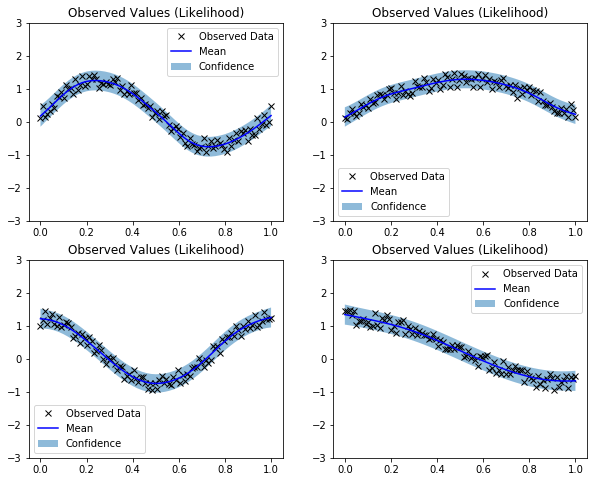

In [27]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, ((y1_ax, y2_ax), (y3_ax, y4_ax)) = plt.subplots(2, 2, figsize=(10, 8))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51).view(1, -1, 1).repeat(4, 1, 1)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()


# Plot training data as black stars
y1_ax.plot(train_x[0].detach().numpy(), train_y[0].detach().numpy(), 'kx')
# Predictive mean as blue line
y1_ax.plot(test_x[0].squeeze().numpy(), mean[0, :].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x[0].squeeze().numpy(), lower[0, :].numpy(), upper[0, :].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

y2_ax.plot(train_x[1].detach().numpy(), train_y[1].detach().numpy(), 'kx')
y2_ax.plot(test_x[1].squeeze().numpy(), mean[1, :].numpy(), 'b')
y2_ax.fill_between(test_x[1].squeeze().numpy(), lower[1, :].numpy(), upper[1, :].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

y3_ax.plot(train_x[2].detach().numpy(), train_y[2].detach().numpy(), 'kx')
y3_ax.plot(test_x[2].squeeze().numpy(), mean[2, :].numpy(), 'b')
y3_ax.fill_between(test_x[2].squeeze().numpy(), lower[2, :].numpy(), upper[2, :].numpy(), alpha=0.5)
y3_ax.set_ylim([-3, 3])
y3_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y3_ax.set_title('Observed Values (Likelihood)')

y4_ax.plot(train_x[3].detach().numpy(), train_y[3].detach().numpy(), 'kx')
y4_ax.plot(test_x[3].squeeze().numpy(), mean[3, :].numpy(), 'b')
y4_ax.fill_between(test_x[3].squeeze().numpy(), lower[3, :].numpy(), upper[3, :].numpy(), alpha=0.5)
y4_ax.set_ylim([-3, 3])
y4_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y4_ax.set_title('Observed Values (Likelihood)')